In [0]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/home/qminers')

Mounted at /content/gdrive


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from qminers.utils import prepare_data_v1

prepare_data = prepare_data_v1

In [0]:
%load_ext autoreload

### Load and prepare data

In [0]:
%autoreload

financial_df = pd.read_csv('data/sp500_2010_01_01-2014_07_31.csv')
calendar_df = pd.read_csv('data/econ_calendar.csv')

data_train_val, data_test = prepare_data(financial_df, calendar_df)

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data_train_val, test_size=0.2, shuffle=False)

# Normalize data

- normalize to [0, 1]
- with clipping?

In [0]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(data_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
def transform_data(data, scaler):
  res = scaler.transform(data)
  res = res.clip(0, 1)
  return res

data_train_transformed = transform_data(data_train, scaler)
data_val_transformed = transform_data(data_val, scaler)
data_test_transformed = transform_data(data_test, scaler)

# Simplest RNN

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


In [0]:
batch_size = 32
sequence_length = 10
lstm_dim = 1

return_sequences = False

In [0]:
# taken from https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019
# custom R2-score metrics for keras backend
from tensorflow.keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#     return SS_res/(SS_tot + K.epsilon())

In [0]:
def create_lstm_model(lstm_dim, sequence_length, data_dim, lr=1e-4):
  inputs = Input(shape=(sequence_length, data_dim,), name='input')

  output = LSTM(lstm_dim, return_sequences=return_sequences)(inputs)
  output = Dense(1)(output)
  
  model = Model(inputs=inputs, outputs=output)
  model.compile(loss='mae',
                optimizer=Adam(lr=lr),
                metrics=[r2_keras, 'mse'])

  model.summary()
  print("lr=%f" % lr)
  return model


def get_data_generator(data, batch_size, sequence_length, training=True):
  batch_x = np.zeros((batch_size, sequence_length, data_train_transformed.shape[1]))
  if return_sequences:
    batch_y = np.zeros((batch_size, sequence_length, 1))
  else:
    batch_y = np.zeros((batch_size, 1))
  
  # -1 because outputs are shifted by +1
  if training:
    # random sample from training data
    rand_inds = np.random.randint(0, data.shape[0] - sequence_length - 1, batch_size)
  else:
    # not random, chronological
    rand_inds = np.arange(start=0, step=sequence_length, stop=data.shape[0] - sequence_length - 1)
  
  while True:
    for i, idx in enumerate(rand_inds):
      end_idx = idx + sequence_length
      batch_x[i] = data[idx:end_idx,:]
      
      if return_sequences:
        batch_y[i] = data[idx + 1:end_idx + 1, -1, np.newaxis]
      else:
        batch_y[i] = data[end_idx, -1]

    yield batch_x, batch_y

In [0]:
data_train_generator = get_data_generator(data_train_transformed, batch_size, sequence_length)
data_val_generator = get_data_generator(data_val_transformed, data_val_transformed.shape[0]//sequence_length, sequence_length, training=False)
data_val_ready = next(data_val_generator)

In [0]:
data_test_generator = get_data_generator(data_test_transformed, data_test_transformed.shape[0]//sequence_length, sequence_length, training=False)
data_test_ready = next(data_test_generator)

## MAE loss

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-5)
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000010
Epoch 1/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.5425 - r2_keras: -19.5037 - mean_squared_error: 0.3123 - val_loss: 0.6542 - val_r2_keras: -160.9826 - val_mean_squared_error: 0.4307
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4927 - r2_keras: -16.0861 - mean_squared_error: 0.2603 - val_loss: 0.6037 - val_r2_keras: -137.1207 - val_m

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 4s 9ms/step - loss: 0.1166 - r2_keras: -0.7207 - mean_squared_error: 0.0262 - val_loss: 0.0714 - val_r2_keras: -1.8936 - val_mean_squared_error: 0.0077
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 0.1058 - r2_keras: -0.5431 - mean_squared_error: 0.0235 - val_loss: 0.0567 - val_r2_keras: -1.0024 - val_mean_squared_error: 0.0053
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0979 - r2_keras: -0.4092 - mean_squared_error: 0.0215 - val_loss: 0.0513 - val_r2_keras: -0.5434 - val_mean_squared_error: 0.0041
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0922 - r2_keras: -0.3053 - mean_squared_error: 0.0199 - val_loss: 0.0470 - val_r2_keras: -0.3051 - val_mean_squared_error: 0.0035
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0886 - r2_keras: -0.2274 - mean_squared_error: 0.0187 - val_loss: 0.0471 - val_r2_keras: -0.2175 - val_me

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0850 - r2_keras: -0.1553 - mean_squared_error: 0.0176 - val_loss: 0.0501 - val_r2_keras: -0.2565 - val_mean_squared_error: 0.0033
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0816 - r2_keras: -0.0926 - mean_squared_error: 0.0166 - val_loss: 0.0548 - val_r2_keras: -0.4645 - val_mean_squared_error: 0.0039
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0784 - r2_keras: -0.0423 - mean_squared_error: 0.0159 - val_loss: 0.0588 - val_r2_keras: -0.7251 - val_mean_squared_error: 0.0046
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0775 - r2_keras: -0.0232 - mean_squared_error: 0.0156 - val_loss: 0.0586 - val_r2_keras: -0.7089 - val_mean_squared_error: 0.0045
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0772 - r2_keras: -0.0154 - mean_squared_error: 0.0155 - val_loss: 0.0576 - val_r2_keras: -0.6398 - val_me

## MSE Loss

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-4)
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1156 - r2_keras: -6.5892 - val_loss: 0.0081 - val_r2_keras: -2.0325
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0421 - r2_keras: -1.7652 - val_loss: 0.0045 - val_r2_keras: -0.6931
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0218 - r2_keras: -0.4325 - val_loss: 0.0062 - val_r2_keras: -1.3403
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0152 - r2_kera

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0067 - r2_keras: 0.5626 - val_loss: 0.0035 - val_r2_keras: -0.3160
Epoch 2/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0064 - r2_keras: 0.5819 - val_loss: 0.0033 - val_r2_keras: -0.2420
Epoch 3/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0061 - r2_keras: 0.6012 - val_loss: 0.0032 - val_r2_keras: -0.1929
Epoch 4/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0058 - r2_keras: 0.6208 - val_loss: 0.0031 - val_r2_keras: -0.1651
Epoch 5/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0054 - r2_keras: 0.6429 - val_loss: 0.0030 - val_r2_keras: -0.1311


In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0048 - r2_keras: 0.6825 - val_loss: 0.0035 - val_r2_keras: -0.3147
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0044 - r2_keras: 0.7143 - val_loss: 0.0034 - val_r2_keras: -0.2920
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0041 - r2_keras: 0.7298 - val_loss: 0.0030 - val_r2_keras: -0.1407
Epoch 4/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0038 - r2_keras: 0.7496 - val_loss: 0.0026 - val_r2_keras: 0.0367
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0033 - r2_keras: 0.7841 - val_loss: 0.0016 - val_r2_keras: 0.4012


In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0028 - r2_keras: 0.8143 - val_loss: 0.0015 - val_r2_keras: 0.4195
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0026 - r2_keras: 0.8272 - val_loss: 0.0016 - val_r2_keras: 0.4165
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0025 - r2_keras: 0.8363 - val_loss: 0.0016 - val_r2_keras: 0.4119
Epoch 4/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0024 - r2_keras: 0.8430 - val_loss: 0.0016 - val_r2_keras: 0.4065
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0023 - r2_keras: 0.8489 - val_loss: 0.0016 - val_r2_keras: 0.3984


In [0]:
predictions = model_rnn.predict(data_val_ready[0])

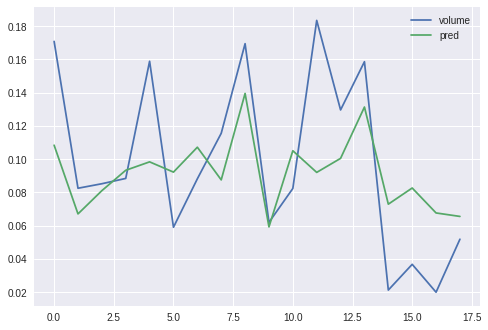

In [0]:
plt.figure()
plt.plot(data_val_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

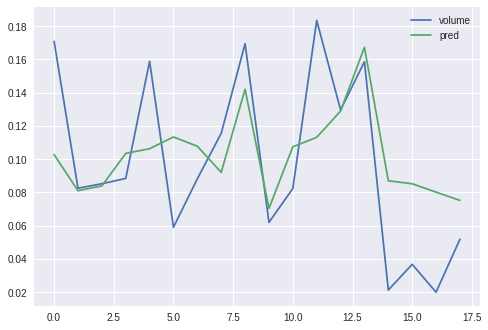

In [0]:
plt.figure()
plt.plot(data_val_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

In [0]:
predictions = model_rnn.predict(data_test_ready[0])

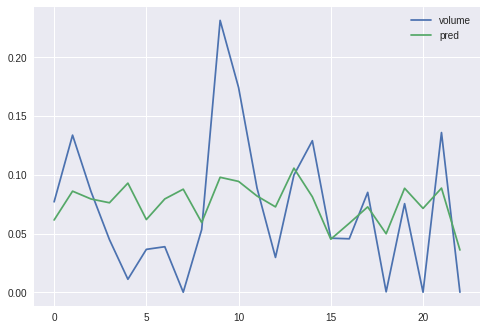

In [0]:
plt.figure()
plt.plot(data_test_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

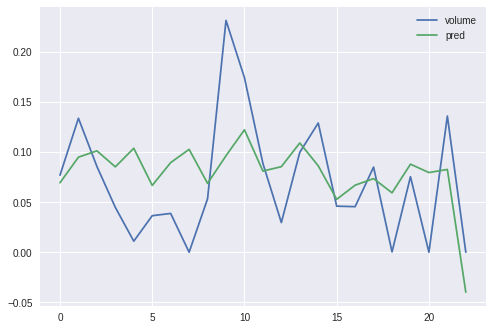

In [0]:
plt.figure()
plt.plot(data_test_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

### 2-layer LSTM

In [0]:
def create_stacked_lstm_model(lstm_dims, sequence_length, data_dim, dropout_pct=None, lr=1e-4):
  inputs = Input(shape=(sequence_length, data_dim,), name='input')
  
  temp = inputs
  for lstm_dim in lstm_dims[:-1]:
    temp = LSTM(lstm_dim, return_sequences=True)(temp)
    
    if dropout_pct is not None:
      temp = Dropout(dropout_pct)(temp)
    
  output = LSTM(lstm_dims[-1], return_sequences=False)(temp)
  output = Dense(1)(output)
  
  model = Model(inputs=inputs, outputs=output)
#   model.compile(loss='mse',
#                 optimizer=Adam(lr=lr),
#                 metrics=[r2_keras])
  model.compile(loss=binary_crossentropy,
                optimizer=Adam(lr=lr),
                metrics=['mse', r2_keras])


  model.summary()
  print("lr=%f" % lr)
  return model

In [0]:
stacked_lstm = create_stacked_lstm_model([1, 1], sequence_length, data_train_transformed.shape[1], dropout_pct=0.5, lr=1e-4)
stacked_lstm.fit_generator(data_train_generator,
          steps_per_epoch=200,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 10, 1)             48        
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 1)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/5
200/200 [==============================] - 11s 56ms/step - loss: 3.0720 - mean_squared_error: 0.1062 - r2_keras: -5.9691 - v

In [0]:
stacked_lstm.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6413 - mean_squared_error: 0.0098 - val_loss: 1.3853 - val_mean_squared_error: 0.0037
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5446 - mean_squared_error: 0.0083 - val_loss: 1.8671 - val_mean_squared_error: 0.0050
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4968 - mean_squared_error: 0.0076 - val_loss: 1.8889 - val_mean_squared_error: 0.0050
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4791 - mean_squared_error: 0.0073 - val_loss: 2.0413 - val_mean_squared_error: 0.0054
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4622 - mean_squared_error: 0.0070 - val_loss: 2.1160 - val_mean_squared_error: 0.0056
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4491 - mean_squared_error: 0.0068 - val_loss: 2.1147 - val_mean_squared_error: 0.0056
Epoc